In [45]:
import pickle,gzip,math,os,time,shutil,torch,matplotlib as mpl,numpy as np,matplotlib.pyplot as plt
from pathlib import Path
from torch import tensor,nn
import torch.nn.functional as F
from fastcore.test import test_close

torch.set_printoptions(precision=2, linewidth=140, sci_mode=False)
torch.manual_seed(1)
mpl.rcParams['image.cmap'] = 'gray'

path_data = Path('data')
path_gz = path_data/'mnist.pkl.gz'
with gzip.open(path_gz, 'rb') as f: ((x_train, y_train), (x_valid, y_valid), _) = pickle.load(f, encoding='latin-1')
x_train, y_train, x_valid, y_valid = map(tensor, [x_train, y_train, x_valid, y_valid])

 ## Data


In [46]:
n, m = x_train.shape
c = y_train.max()+1
nh = 50
n, m, c

(50000, 784, tensor(10))

In [47]:
class Model(nn.Module):
    def __init__(self, n_in, nh, n_out):
        super().__init__()
        self.layers = [nn.Linear(n_in,nh), nn.ReLU(), nn.Linear(nh, n_out)]
    def forward(self, x):
        for l in self.layers:
            x = l(x)
        return x

In [78]:
model = Model(m, nh, c)
pred = model(x_train)
pred.shape

torch.Size([50000, 10])

## Basic training loop

In [49]:
loss_func = F.cross_entropy

In [50]:
bs =64

xb = x_train[0:bs]
preds = model(xb)
preds[0], preds.shape

(tensor([-0.09, -0.21, -0.08,  0.10, -0.04,  0.08, -0.04, -0.03,  0.01,  0.06], grad_fn=<SelectBackward0>),
 torch.Size([64, 10]))

In [51]:
yb = y_train[0:bs]
loss_func(preds, yb)

tensor(2.30, grad_fn=<NllLossBackward0>)

In [52]:
preds.argmax(dim=1)

tensor([3, 9, 3, 8, 5, 9, 3, 9, 3, 9, 5, 3, 9, 9, 3, 9, 9, 5, 8, 7, 9, 5, 3, 8, 9, 5, 9, 5, 5, 9, 3, 5, 9, 7, 5, 7, 9, 9, 3, 9, 3, 5, 3, 8,
        3, 5, 9, 5, 9, 5, 3, 9, 3, 8, 9, 5, 9, 5, 9, 5, 8, 8, 9, 8])

In [53]:
def accuracy(out, yb):
    return (out.argmax(dim=1)==yb).float().mean()

In [54]:
lr = 0.5
epochs = 3

In [55]:
def report(loss, preds, yb):
    print(f'{loss:.2f}, {accuracy(preds, yb):.2f}')

In [56]:
for epoch in range(epochs):
    for i in range(0, n, bs):
        s = slice(i, min(n,i+bs))
        xb, yb = x_train[s], y_train[s]
        preds = model(xb)
        loss = loss_func(preds, yb)
        loss.backward()
        with torch.no_grad():
            for l in model.layers:
                if hasattr(l, 'weight'):
                    l.weight -= l.weight.grad * lr
                    l.bias -= l.bias.grad * lr
                    l.weight.grad.zero_()
                    l.bias.grad.zero_()
    report(loss, preds, yb)

0.19, 0.94
0.05, 1.00
0.03, 1.00


## Using parameters and optim

### Parameters

In [81]:
m1 = nn.Module()
m1.foo = nn.Linear(3,4)

In [58]:
m1

Module(
  (foo): Linear(in_features=3, out_features=4, bias=True)
)

In [59]:
list(m1.named_children())

[('foo', Linear(in_features=3, out_features=4, bias=True))]

In [60]:
list(m1.parameters())

[Parameter containing:
 tensor([[ 0.57,  0.43, -0.30],
         [ 0.13, -0.32, -0.24],
         [ 0.51,  0.04,  0.22],
         [ 0.13, -0.17, -0.24]], requires_grad=True),
 Parameter containing:
 tensor([-0.01, -0.51, -0.39,  0.56], requires_grad=True)]

In [68]:
class MLP(nn.Module):
    def __init__(self, n_in, nh, n_out):
        super().__init__()
        self.l1 = nn.Linear(n_in, nh)
        self.l2 = nn.Linear(nh, n_out)
        self.relu = nn.ReLU()
    
    def forward(self, x):
        return self.l2(self.relu(self.l1(x)))
    

In [82]:
model = MLP(m, nh, 10)
model.l1

Linear(in_features=784, out_features=50, bias=True)

In [70]:
model

MLP(
  (l1): Linear(in_features=784, out_features=50, bias=True)
  (l2): Linear(in_features=50, out_features=10, bias=True)
  (relu): ReLU()
)

In [72]:
for name,l in model.named_children():
    print(f"{name}: {l}")

l1: Linear(in_features=784, out_features=50, bias=True)
l2: Linear(in_features=50, out_features=10, bias=True)
relu: ReLU()


In [73]:
for p in model.parameters():
    print(p.shape)

torch.Size([50, 784])
torch.Size([50])
torch.Size([10, 50])
torch.Size([10])


In [75]:
F.linear??

In [79]:
def fit():
    for epoch in range(epochs):
        for i in range(0, n, bs):
            s = slice(i, min(n, i+bs))
            xb, yb = x_train[s], y_train[s]
            preds = model(xb)
            loss = loss_func(preds, yb)
            loss.backward()
            with torch.no_grad():
                for p in model.parameters():
                    p -= p.grad * lr
                model.zero_grad()
        report(loss, preds, yb)

In [83]:
fit()

0.23, 0.88
0.18, 0.88
0.08, 1.00


In [92]:
class MyModule():
    def __init__(self, n_in, nh, n_out):
        self._modules = {}
        self.l1 = nn.Linear(n_in, nh)
        self.l2 = nn.Linear(nh, n_out)
    
    def __setattr__(self, k, v):
        if not k.startswith("_"):
            self._modules[k] = v
        super().__setattr__(k,v)
    
    def __repr__(self):
        return f'{self._modules}'
    
    def parameters(self):
        for l in self._modules.values():
            #for p in l.parameters():
            #    yield p
            yield from l.parameters()

In [93]:
mdl = MyModule(m, nh, 10)
mdl

{'l1': Linear(in_features=784, out_features=50, bias=True), 'l2': Linear(in_features=50, out_features=10, bias=True)}

In [94]:
for p in mdl.parameters():
    print(p.shape)

torch.Size([50, 784])
torch.Size([50])
torch.Size([10, 50])
torch.Size([10])


## Registering modules

In [95]:
from functools import reduce

In [96]:
layers = [nn.Linear(m, nh), nn.ReLU(), nn.Linear(nh,10)]

In [99]:
class Model(nn.Module):
    def __init__(self, layers):
        super().__init__()
        self.layers = layers
        for i,l in enumerate(self.layers):
            self.add_module(f'layer_{i}',l)
            
        def forward(self, x):
            return reduce(lambda val,layer: layer(val),self.layers, x)

In [100]:
model = Model(layers)
model

Model(
  (layer_0): Linear(in_features=784, out_features=50, bias=True)
  (layer_1): ReLU()
  (layer_2): Linear(in_features=50, out_features=10, bias=True)
)

In [103]:
class SequentialModel(nn.Module):
    def __init__(self, layers):
        super().__init__()
        self.layers = nn.ModuleList(layers)
        
    def forward(self, x):
        for l in self.layers:
            x = l(x)
        return x

In [104]:
model = SequentialModel(layers)
model

SequentialModel(
  (layers): ModuleList(
    (0): Linear(in_features=784, out_features=50, bias=True)
    (1): ReLU()
    (2): Linear(in_features=50, out_features=10, bias=True)
  )
)

In [106]:
fit()
loss_func(model(xb), yb), accuracy(model(xb),yb) 

0.26, 0.94
0.08, 0.94
0.03, 1.00


(tensor(0.01, grad_fn=<NllLossBackward0>), tensor(1.))

## nn.Sequential

In [107]:
model = nn.Sequential(nn.Linear(m, nh), nn.ReLU(), nn.Linear(nh, 10))

In [108]:
fit()
loss_func(model(xb), yb), accuracy(model(xb),yb) 

0.29, 0.94
0.15, 0.94
0.06, 1.00


(tensor(0.01, grad_fn=<NllLossBackward0>), tensor(1.))

In [109]:
model

Sequential(
  (0): Linear(in_features=784, out_features=50, bias=True)
  (1): ReLU()
  (2): Linear(in_features=50, out_features=10, bias=True)
)

## optim

In [111]:
class Optimizer():
    def __init__(self, params, lr = 0.5):
        self.params , self.lr = list(params), lr
        
    def step(self):
        with torch.no_grad():
            for p in self.params: p-= p.grad * self.lr
                
    def zero_grad(self):
        for p in self.params:
            p.grad.data.zero_()

In [112]:
model = nn.Sequential(nn.Linear(m, nh), nn.ReLU(), nn.Linear(nh, 10))

In [114]:
opt = Optimizer(model.parameters())

In [115]:
for epoch in range(epochs):
    for i in range(0, n, bs):
        s = slice(i, min(n,i+bs))
        xb, yb  = x_train[s], y_train[s]
        preds = model(xb)
        loss = loss_func(preds, yb)
        loss.backward()
        opt.step()
        opt.zero_grad()
    report(loss, preds, yb)

0.20, 0.94
0.05, 1.00
0.07, 1.00


In [116]:
from torch import optim

In [117]:
def get_model():
    model = nn.Sequential(nn.Linear(m, nh), nn.ReLU(), nn.Linear(nh, 10))
    return model, optim.SGD(model.parameters(), lr=lr)

In [118]:
model, opt = get_model()
loss_func(model(xb), yb)

tensor(2.30, grad_fn=<NllLossBackward0>)

In [119]:
for epoch in range(epochs):
    for i in range(0, n, bs):
        s = slice(i, min(n,i+bs))
        xb,yb = x_train[s], y_train[s]
        preds = model(xb)
        loss = loss_func(preds, yb)
        loss.backward()
        opt.step()
        opt.zero_grad()
    report(loss, preds, yb)

0.14, 0.94
0.04, 1.00
0.02, 1.00


In [120]:
class Dataset():
    def __init__(self, x, y):
        self.x, self.y = x, y
    def __len__(self):
        return len(self.x)
    def __getitem__(self, i):
        return self.x[i], self.y[i]

In [124]:
train_ds, valid_ds = Dataset(x_train, y_train), Dataset(x_valid, y_valid)
assert len(train_ds) == len(x_train)
assert len(valid_ds) == len(x_valid)

In [125]:
xb, yb = train_ds[0:5]
assert xb.shape==(5,28*28)
assert yb.shape==(5,)

In [126]:
model,opt = get_model()

In [127]:
for epoch in range(epochs):
    for i in range(0, n, bs):
        xb,yb = train_ds[i:min(n,i+bs)]
        preds = model(xb)
        loss = loss_func(preds, yb)
        loss.backward()
        opt.step()
        opt.zero_grad()
    report(loss, preds, yb)

0.29, 0.94
0.18, 0.88
0.09, 1.00


In [128]:
class Dataloader():
    def __init__(self, ds, bs):
        self.ds, self.bs = ds, bs
    def __iter__(self):
        for i in range(0, len(self.ds), self.bs):
            yield self.ds[i:i+self.bs]

In [129]:
train_dl = Dataloader(train_ds, bs)
valid_dl = Dataloader(valid_ds, bs)

In [130]:
xb, yb = next(iter(valid_dl))
xb.shape

torch.Size([64, 784])

In [131]:
yb

tensor([3, 8, 6, 9, 6, 4, 5, 3, 8, 4, 5, 2, 3, 8, 4, 8, 1, 5, 0, 5, 9, 7, 4, 1, 0, 3, 0, 6, 2, 9, 9, 4, 1, 3, 6, 8, 0, 7, 7, 6, 8, 9, 0, 3,
        8, 3, 7, 7, 8, 4, 4, 1, 2, 9, 8, 1, 1, 0, 6, 6, 5, 0, 1, 1])

tensor(3)

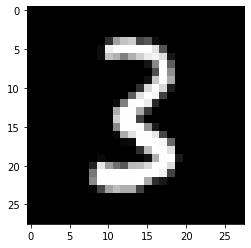

In [135]:
plt.imshow(xb[0].view(28,28))
yb[0]

In [139]:
model, opt = get_model()

In [140]:
def fit():
    for epoch in range(epochs):
        for xb,yb in train_dl:
            pred = model(xb)
            loss = loss_func(pred, yb)
            loss.backward()
            opt.step()
            opt.zero_grad()
        report(loss, preds, yb)

In [141]:
fit()
loss_func(model(xb), yb), accuracy(model(xb), yb)

0.20, 1.00
0.07, 1.00
0.03, 1.00


(tensor(0.07, grad_fn=<NllLossBackward0>), tensor(0.98))

## random sampling

In [142]:
import random

In [150]:
class Sampler():
    def __init__(self, ds, shuffle=False):
        self.n, self.shuffle = len(ds), shuffle
        
    def __iter__(self):
        res = list(range(self.n))
        if self.shuffle:
            random.shuffle(res)
        return iter(res)

In [151]:
from itertools import islice

In [152]:
ss = Sampler(train_ds)

In [153]:
it = iter(ss)
for o in range(5):
    print(next(it))

0
1
2
3
4


In [154]:
list(islice(ss,5))

[0, 1, 2, 3, 4]

In [158]:
ss = Sampler(train_ds, shuffle=True)
list(islice(ss, 5))

[6882, 8881, 6752, 8786, 36618]

In [163]:
list(islice(ss, 5))

[21527, 28513, 29486, 46655, 40314]

In [156]:
import fastcore.all as fc

In [157]:
class BatchSampler():
    def __init__(self, sampler, bs, drop_last = False):
        self.sampler, self.bs, self.drop_last = sampler, bs, drop_last
        
    def __iter__(self):
        yield from fc.chunked(iter(self.sampler), self.bs, drop_last = self.drop_last)

In [164]:
batchs = BatchSampler(ss, 4)
list(islice(batchs,5))

[[4180, 49388, 44035, 25436],
 [22119, 19311, 7929, 8742],
 [25140, 49480, 903, 26122],
 [4952, 2633, 27737, 47503],
 [28032, 28774, 22609, 13076]]

In [166]:
fc.chunked??

In [167]:
def collate(b):
    xs, ys = zip(*b)
    return torch.stack(xs), torch.stack(ys)

In [168]:
class Dataloader():
    def __init__(self, ds, batchs, collate_fn=collate):
        fc.store_attr()
    def __iter__(self):
        yield from (self.collate_fn(self.ds[i] for i in b) for b in self.batchs)

In [169]:
train_samp = BatchSampler(Sampler(train_ds, shuffle=True), bs)
valid_samp = BatchSampler(Sampler(valid_ds, shuffle=False), bs)

In [170]:
train_dl = Dataloader(train_ds, batchs=train_samp)
valid_dl = Dataloader(valid_ds, batchs=valid_samp)

tensor(3)

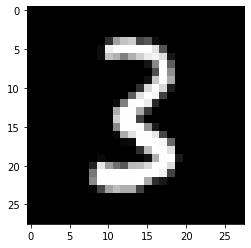

In [171]:
xb, yb = next(iter(valid_dl))
plt.imshow(xb[0].view(28,28))
yb[0]